In [1]:
from duration_processor import load_quiz_data
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

from writing_evaluator import (
    extract_modifying_tabular_tasks,
    plot_tabular_metrics_by_format
)

df_tabular = extract_modifying_tabular_tasks(all_data, format_list=['hjson','json','xml','jsonc','json5', 'yaml', 'toml'])
df_tabular.head(10)

,participantId,format,task,code,startTime,endTime,duration_sec,helpButtonClickedCount
0,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-json5-1,{\n movies: {\n movie: [\n ...,1746561974479,1746562131384,156.905,1
1,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-json5-2,{\n movies: {\n movie: [\n ...,1746562139237,1746562218539,79.302,0
2,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-json5-3,{\n movies: {\n movie: [\n ...,1746562223954,1746562287705,63.751,0
3,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-json5-4,{\n movies: {\n movie: [\n ...,1746562292771,1746562421890,129.119,0
4,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-1,{\n movies:\n {\n movie:\n [\n {\...,1745933151075,1745933462717,311.642,0
5,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-2,{\n movies:\n {\n movie:\n [\n {\...,1745933472523,1745933563691,91.168,0
6,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-3,None,1745933569792,1745933692031,122.239,0
7,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-4,{\n movies:\n {\n movie:\n [\n {\...,1745933701669,1745933938010,236.341,0
8,67e25388d573ec2d5f1c8442,yaml,modifying-task-tabular-yaml-1,movies:\n movie:\n - title: After Dark in ...,1746147382803,1746147671485,288.682,0
9,67e25388d573ec2d5f1c8442,yaml,modifying-task-tabular-yaml-2,movies:\n movie:\n - title: After Dark in ...,1746147676874,1746147831224,154.350,0


In [17]:
import pandas as pd
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def aggregate_participant_level(df):
    """聚合每个参与者在所有 modifying-tabular 任务中的总 duration/help 点击"""
    agg_df = (
        df.groupby(['participantId', 'format'])
          .agg(
              total_duration_sec=('duration_sec', 'sum'),
              total_help_clicks=('helpButtonClickedCount', 'sum')
          )
          .reset_index()
    )
    return agg_df

def test_format_differences(df, metrics, format_col='format', alpha=0.05):
    results = {}
    for metric in metrics:
        if metric not in df.columns:
            continue
        df_sub = df[[format_col, metric]].dropna()
        groups = [g[metric].values for _, g in df_sub.groupby(format_col)]
        if len(groups) < 2:
            continue
        W, p_levene = levene(*groups)
        if p_levene > alpha:
            stat, pval = f_oneway(*groups)
            method = 'ANOVA'
        else:
            stat, pval = kruskal(*groups)
            method = 'Kruskal–Wallis'
        tukey = None
        if method == 'ANOVA' and pval < alpha:
            tukey = pairwise_tukeyhsd(
                endog=df_sub[metric],
                groups=df_sub[format_col],
                alpha=alpha
            )
        hom = 'homogeneous' if p_levene > alpha else 'heterogeneous'
        interpretation = (
            f"Levene’s test for '{metric}': W = {W:.3f}, p = {p_levene:.3f} ({hom} variances). "
        )
        if pval < alpha:
            interpretation += (
                f"{method}: stat = {stat:.3f}, p = {pval:.3f} → Significant differences exist."
            )
        else:
            interpretation += (
                f"{method}: stat = {stat:.3f}, p = {pval:.3f} → No significant differences."
            )
        results[metric] = {
            'levene': (W, p_levene),
            'method': method,
            'stat': stat,
            'p_value': pval,
            'tukey': tukey,
            'interpretation': interpretation
        }
    return results

def test_each_task_by_format_multitask(
    df,
    task_col=['task_cleaned'],
    format_col='format',
    metrics=['duration_sec', 'helpButtonClickedCount'],
    alpha=0.05
):
    """
    对每个 task_cleaned 值，在不同 format 组间比较指定数值指标的显著性差异。
    自动按 participantId + task_cleaned 聚合多个任务版本（如 -1、-2、-3）。

    参数：
      df         原始 DataFrame
      task_col   一列或多列任务名，如 'task_cleaned'
      format_col format 列名
      metrics    数值列
      alpha      显著性水平

    返回：
      嵌套 dict: { task_col -> { task_val -> { metric -> 检验结果 } } }
    """
    if isinstance(task_col, str):
        task_col = [task_col]

    all_results = {}

    for col in task_col:
        # 先聚合：每个 participantId、每个 task_cleaned 取汇总
        grouped = (
            df.groupby(['participantId', format_col, col])[metrics]
            .sum()
            .reset_index()
        )

        result_per_col = {}

        for task_val in grouped[col].dropna().unique():
            task_df = grouped[grouped[col] == task_val]
            task_results = {}

            for metric in metrics:
                if metric not in task_df.columns:
                    continue

                sub = task_df[[format_col, metric]].dropna()
                if sub[format_col].nunique() < 2:
                    continue

                groups = [g[metric].values for _, g in sub.groupby(format_col)]
                W, p_levene = levene(*groups)

                if p_levene > alpha:
                    stat, pval = f_oneway(*groups)
                    method = 'ANOVA'
                else:
                    try:
                        stat, pval = kruskal(*groups)
                    except ValueError:
                        stat, pval = 0.0, 1.0
                    method = 'Kruskal–Wallis'

                tukey = None
                if method == 'ANOVA' and pval < alpha:
                    tukey = pairwise_tukeyhsd(
                        endog=sub[metric],
                        groups=sub[format_col],
                        alpha=alpha
                    )

                hom = 'homogeneous' if p_levene > alpha else 'heterogeneous'
                interp = (
                    f"[{task_val}] Levene’s p = {p_levene:.3f} ({hom} variances). "
                )
                if pval < alpha:
                    interp += (
                        f"{method} p = {pval:.3f} (< {alpha}): significant format differences on {metric}."
                    )
                    if tukey is not None:
                        interp += " See Tukey HSD for details."
                else:
                    interp += (
                        f"{method} p = {pval:.3f} (≥ {alpha}): no significant format differences on {metric}."
                    )

                task_results[metric] = {
                    'levene': (W, p_levene),
                    'method': method,
                    'stat': stat,
                    'p_value': pval,
                    'tukey': tukey,
                    'interpretation': interp
                }

            result_per_col[task_val] = task_results

        all_results[col] = result_per_col

    return all_results


In [13]:
df_tabular

,participantId,format,task,code,startTime,endTime,duration_sec,helpButtonClickedCount
0,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-1,{\n movies:\n {\n movie:\n [\n {\...,1745933151075,1745933462717,311.642,0
1,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-2,{\n movies:\n {\n movie:\n [\n {\...,1745933472523,1745933563691,91.168,0
2,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-3,None,1745933569792,1745933692031,122.239,0
3,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-4,{\n movies:\n {\n movie:\n [\n {\...,1745933701669,1745933938010,236.341,0
4,67e25388d573ec2d5f1c8442,yaml,modifying-task-tabular-yaml-1,movies:\n movie:\n - title: After Dark in ...,1746147382803,1746147671485,288.682,0
...,...,...,...,...,...,...,...,...
415,67adb27bd5f5776fcb16da62,hjson,modifying-task-tabular-hjson-4,{\n movies:\n {\n movie:\n [\n {\...,1746147371849,1746147498661,126.812,1
416,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-hjson-1,{\n movies:\n {\n movie:\n [\n {\...,1746235267755,1746235543167,275.412,0
417,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-hjson-2,{\n movies:\n {\n movie:\n [\n {\...,1746235551599,1746235644075,92.476,0
418,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-hjson-3,{\n movies:\n {\n movie:\n [\n {\...,1746235649569,1746235722850,73.281,0


In [20]:
import re

df_tabular['task_cleaned'] = df_tabular['task'].str.replace(r'-(\w+)-(\d+)$', r'-\2', regex=True)


results = test_each_task_by_format_multitask(
    df_tabular,
    task_col='task_cleaned',
    format_col='format',
    metrics=['duration_sec', 'helpButtonClickedCount'],
    alpha=0.05
)

for colname, task_dict in results.items():
    print(f"\n=== Task Column: {colname} ===")
    for task_val, metric_dict in task_dict.items():
        print(f"\n-- Task: {task_val} --")
        for metric, info in metric_dict.items():
            print(f"  - {metric}: {info['interpretation']}")
            if info['tukey'] is not None:
                print(info['tukey'].summary())


=== Task Column: task_cleaned ===

-- Task: modifying-task-tabular-1 --
  - duration_sec: [modifying-task-tabular-1] Levene’s p = 0.864 (homogeneous variances). ANOVA p = 0.617 (≥ 0.05): no significant format differences on duration_sec.
  - helpButtonClickedCount: [modifying-task-tabular-1] Levene’s p = 0.206 (homogeneous variances). ANOVA p = 0.206 (≥ 0.05): no significant format differences on helpButtonClickedCount.

-- Task: modifying-task-tabular-2 --
  - duration_sec: [modifying-task-tabular-2] Levene’s p = 0.979 (homogeneous variances). ANOVA p = 0.821 (≥ 0.05): no significant format differences on duration_sec.
  - helpButtonClickedCount: [modifying-task-tabular-2] Levene’s p = 0.430 (homogeneous variances). ANOVA p = 0.430 (≥ 0.05): no significant format differences on helpButtonClickedCount.

-- Task: modifying-task-tabular-3 --
  - duration_sec: [modifying-task-tabular-3] Levene’s p = 0.577 (homogeneous variances). ANOVA p = 0.010 (< 0.05): significant format differences o

In [5]:
# 1. 聚合参与者总的 modifying-tabular 时间 + 帮助点击
agg_df = aggregate_participant_level(df_tabular)

# 2. 检验每个参与者在各格式的总时间/点击显著性差异
print("=== Aggregated Metrics by Participant ===")
results_agg = test_format_differences(
    agg_df,
    metrics=['total_duration_sec', 'total_help_clicks'],
    format_col='format'
)
for metric, info in results_agg.items():
    print(f"\n=== Metric: {metric} ===")
    print(info['interpretation'])
    if info['tukey'] is not None:
        print(info['tukey'].summary())


=== Aggregated Metrics by Participant ===

=== Metric: total_duration_sec ===
Levene’s test for 'total_duration_sec': W = 0.416, p = 0.867 (homogeneous variances). ANOVA: stat = 1.444, p = 0.206 → No significant differences.

=== Metric: total_help_clicks ===
Levene’s test for 'total_help_clicks': W = 1.666, p = 0.138 (homogeneous variances). ANOVA: stat = 1.666, p = 0.138 → No significant differences.

=== Original Task-Level Data ===

=== Metric: duration_sec ===
Levene’s test for 'duration_sec': W = 0.550, p = 0.770 (homogeneous variances). ANOVA: stat = 2.023, p = 0.061 → No significant differences.

=== Metric: helpButtonClickedCount ===
Levene’s test for 'helpButtonClickedCount': W = 1.798, p = 0.098 (homogeneous variances). ANOVA: stat = 1.798, p = 0.098 → No significant differences.


In [21]:
from linter import plot_avg_total_changes_by_format, plot_syntax_pass_rates, analyze_tabular_writing_diff,batch_tree_distance_analysis, validate_tabular_syntax_all, summarize_syntax_pass_rates # 假设文件名就是 writing_tabular_analysis.py

from writing_evaluator import extract_writing_tabular_tasks
# —————————————————————————————————————————————
# 3. 方法一：简单严格语法校验
# —————————————————————————————————————————————
df_checked = validate_tabular_syntax_all(
    df_tabular,
    code_col='code',
    format_col='format',
    strict_col='syntax_strict',
    loose_col='syntax_loose',
    repair_col='syntax_repair'
)


summary_df = summarize_syntax_pass_rates(df_checked)
summary_df

/opt/anaconda3/lib/python3.8/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


              participantId format                            task  \
0  6697c8b6d9d7baa7edd8c4d3  hjson  modifying-task-tabular-hjson-1   
1  6697c8b6d9d7baa7edd8c4d3  hjson  modifying-task-tabular-hjson-2   
2  6697c8b6d9d7baa7edd8c4d3  hjson  modifying-task-tabular-hjson-3   
3  6697c8b6d9d7baa7edd8c4d3  hjson  modifying-task-tabular-hjson-4   
4  67e25388d573ec2d5f1c8442   yaml   modifying-task-tabular-yaml-1   

                                                code      startTime  \
0  {\n  movies:\n  {\n    movie:\n    [\n      {\...  1745933151075   
1  {\n  movies:\n  {\n    movie:\n    [\n      {\...  1745933472523   
2                                               None  1745933569792   
3  {\n  movies:\n  {\n    movie:\n    [\n      {\...  1745933701669   
4  movies:\n  movie:\n    - title: After Dark in ...  1746147382803   

         endTime  duration_sec  helpButtonClickedCount  \
0  1745933462717       311.642                       0   
1  1745933563691        91.168      

,format,strict_pass_rate,loose_pass_rate,repair_pass_rate
0,hjson,0.816667,0.000000,0.0
1,json,0.529412,0.062500,0.0
2,json5,0.403846,0.612903,0.0
3,jsonc,0.400000,0.000000,0.0
4,toml,0.816667,0.000000,0.0
5,xml,0.633333,0.000000,0.0
6,yaml,0.716667,0.000000,0.0


/opt/anaconda3/lib/python3.8/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


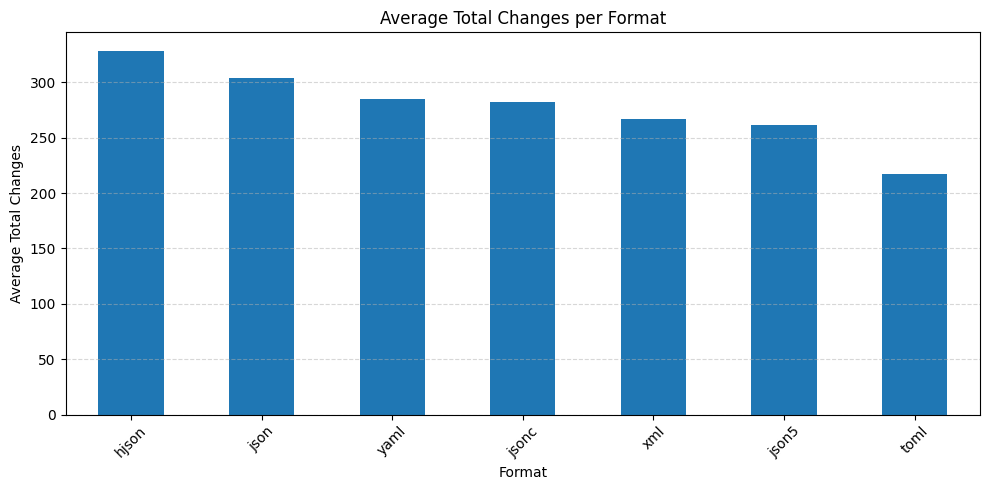

,participantId,format,task,syntax_valid,num_added_lines,num_removed_lines,total_changes,diff_text
0,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-1,1,238,105,343,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
1,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-2,1,240,105,345,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
2,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-3,0,0,107,107,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
3,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-4,0,247,105,352,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
4,67e25388d573ec2d5f1c8442,yaml,modifying-task-tabular-1,1,200,96,296,diff --git a/var/folders/hs/htjkkv116fv94g1llc...


In [2]:
from linter import analyze_tabular_modifying_diff, plot_avg_total_changes_by_format
from writing_evaluator import extract_writing_tabular_tasks

# 唯一标准答案（作为所有 task 使用的“正确 JSON”）
vega_lite_config = {
    "name": "vega-lite",
    "author": "Dominik Moritz, Kanit Wongsuphasawat, Arvind Satyanarayan, Jeffrey Heer",
    "version": "5.23.0",
    "collaborators": [
        "Kanit Wongsuphasawat",
        "Dominik Moritz",
        "Arvind Satyanarayan",
        "Jeffrey Heer"
    ],
    "homepage": "vega.github.io/vega-lite/",
    "description": "Vega-Lite is a concise high-level language for interactive visualization.",
    "keywords": ["vega", "chart", "visualization"],
    "main": "build/vega-lite.js",
    "unpkg": "build/vega-lite.min.js",
    "jsdelivr": "build/vega-lite.min.js",
    "module": "build/src/index",
    "types": "build/src/index.d.ts",
    "bin": {
        "vl2pdf": "./bin/vl2pdf",
        "vl2png": "./bin/vl2png",
        "vl2svg": "./bin/vl2svg",
        "vl2vg": "./bin/vl2vg"
    },
    "files": ["bin", "build", "src", "vega-lite*", "tsconfig.json"],
    "scripts": {
        "changelog": "conventional-changelog -p angular -r",
        "prebuild": "yarn clean:build",
        "build": "yarn build:only",
        "data": "rsync -r node_modules/vega-datasets/data/* site/data",
        "build-editor-preview": "scripts/build-editor-preview.sh",
        "schema": "mkdir -p build && ts-json-schema-generator -f tsconfig.json -p src/index.ts -t TopLevelSpec --no-type-check --no-ref-encode > build/vega-lite-schema.json && yarn renameschema && cp build/vega-lite-schema.json site/_data/",
        "renameschema": "scripts/rename-schema.sh",
        "presite": "yarn data && yarn schema && yarn build:site && yarn build:versions && scripts/create-example-pages.sh",
        "site": "yarn site:only",
        "format": "eslint . --fix && yarn prettierbase --write",
        "lint": "eslint . && yarn prettierbase --check",
        "test": "yarn jest test/ && yarn lint && yarn schema && yarn jest examples/ && yarn",
        "release": "release-it"
    },
    "repository": {
        "type": "git",
        "url": "github.com/vega/vega-lite.git"
    },
    "license": "BSD-3-Clause",
    "bugs": {
        "url": "github.com/vega/vega-lite/issues"
    },
    "devDependencies": {
        "ajv": "^8.17.1",
        "ajv-formats": "^3.0.1",
        "cheerio": "^1.0.0",
        "conventional-changelog-cli": "^5.0.0",
        "d3": "^7.9.0",
        "del-cli": "^6.0.0",
        "eslint": "^8.57.0",
        "eslint-config-prettier": "^9.1.0",
        "eslint-plugin-jest": "^28.11.0",
        "eslint-plugin-prettier": "^5.2.1",
        "fast-json-stable-stringify": "~2.1.0",
        "highlight.js": "^11.11.1",
        "jest": "^29.7.0",
        "jest-dev-server": "^11.0.0",
        "mkdirp": "^3.0.1",
        "pako": "^2.1.0",
        "prettier": "^3.4.2",
        "puppeteer": "^15.0.0",
        "release-it": "18.1.2",
        "rollup": "^4.32.1",
        "rollup-plugin-bundle-size": "^1.0.3",
        "serve": "^14.2.4",
        "terser": "^5.37.0",
        "ts-jest": "^29.2.5",
        "ts-json-schema-generator": "^2.3.0",
        "typescript": "~5.7.3",
        "vega-cli": "^5.31.0",
        "vega-datasets": "^2.11.0",
        "vega-embed": "^6.29.0",
        "vega-tooltip": "^0.35.2",
        "yaml-front-matter": "^4.1.1"
    },
    "dependencies": {
        "json-stringify-pretty-compact": "~4.0.0",
        "tslib": "~2.8.1",
        "vega-event-selector": "~3.0.1",
        "vega-expression": "~5.1.2",
        "vega-util": "~1.17.3",
        "yargs": "~17.7.2"
    },
    "peerDependencies": {
        "vega": "^5.31.0"
    },
    "engines": {
        "node": ">=18"
    },
    "packageManager": "yarn@1.22.22"
}

# 将四个任务映射到同一个标准答案
correct_data_dict = {
    f"modifying-task-tabular-{i}": vega_lite_config
    for i in range(1, 5)
}

# 执行差异分析
df_diff_mod = analyze_tabular_modifying_diff(all_data, correct_data_dict)

# 可视化平均改动数
plot_avg_total_changes_by_format(df_diff_mod)

# 输出前几行检查
df_diff_mod.head()


In [ ]:
import re
import pandas as pd
import json
from linter import compare_structures_tree_edit_distance

def batch_tree_distance_analysis_tree_only_modifying(all_data, correct_json_obj, gold_format="json"):
    """
    针对 modifying-task-tabular-1 ~ 4，分析用户答案与标准结构之间的 Tree Edit Distance（结构相似度）

    Args:
        all_data: dict，所有用户答题数据
        correct_json_obj: dict，结构标准答案（统一结构）
        gold_format: str，标准格式（如 "json"）

    Returns:
        pd.DataFrame 包含 participantId、format、task、similarity_score、normalized_ted 等字段
    """
    gold_struct_code = json.dumps(correct_json_obj, indent=2)
    results = []

    for file_name, quiz_data in all_data.items():
        answers = quiz_data.get('answers', {})

        # 获取 participantId
        participant_id = file_name
        for v in answers.values():
            if isinstance(v, dict):
                a = v.get("answer", {})
                if isinstance(a, dict) and "prolificId" in a:
                    participant_id = a["prolificId"]
                    break

        for task_key, content in answers.items():
            if not isinstance(content, dict):
                continue

            # 仅处理 modifying-task-tabular-1 ~ 4
            if not re.match(r"^modifying-task-tabular-\w+-\d+$", task_key):
                continue

            ans_block = content.get("answer", {})
            code = ans_block.get("code") if isinstance(ans_block, dict) else None
            if not code:
                continue

            # 自动推断格式
            fmt_guess = task_key.replace("modifying-task-tabular-", "").split("-")[0].lower()

            # Tree Edit Distance 分析
            try:
                ted_result = compare_structures_tree_edit_distance(
                    gold_struct_code,
                    code,
                    fmt1=gold_format,
                    fmt2=fmt_guess
                )
                ted = ted_result.get("ted")
                norm_ted = ted_result.get("normalized_ted")
                sim = ted_result.get("similarity_score")
                size1 = ted_result.get("tree_size1")
                size2 = ted_result.get("tree_size2")
                err = ted_result.get("error", "")
            except Exception as e:
                ted = None
                norm_ted = 1.0
                sim = 0.0
                size1 = None
                size2 = None
                err = f"TED error: {e}"

            results.append({
                "participantId": participant_id,
                "format": fmt_guess,
                "task": task_key,
                "ted": ted,
                "normalized_ted": norm_ted,
                "similarity_score": sim,
                "gold_tree_size": size1,
                "user_tree_size": size2,
                "error": err
            })

    return pd.DataFrame(results)


In [ ]:
# 正确结构（你提供的 JSON）
correct_json = {
    "name": "vega-lite",
    "version": "5.23.0",
    "description": "Vega-Lite is a concise high-level language for interactive visualization.",
    "collaborators": ["Kanit", "Dominik", "Arvind", "Jeffrey"],
    "keywords": ["vega", "chart", "visualization"],
    "license": "BSD-3-Clause",
    "repository": {
        "type": "git",
        "url": "github.com/vega/vega-lite.git"
    }
}

# 执行分析
df_ted_modifying = batch_tree_distance_analysis_tree_only_modifying(
    all_data,
    correct_json_obj=correct_json,
    gold_format="json"  # 或你希望的结构格式
)

# 查看和可视化
from linter import calculate_format_similarity_stats, visualize_format_similarity
df_stats_modifying = calculate_format_similarity_stats(df_ted_modifying)
visualize_format_similarity(df_stats_modifying)


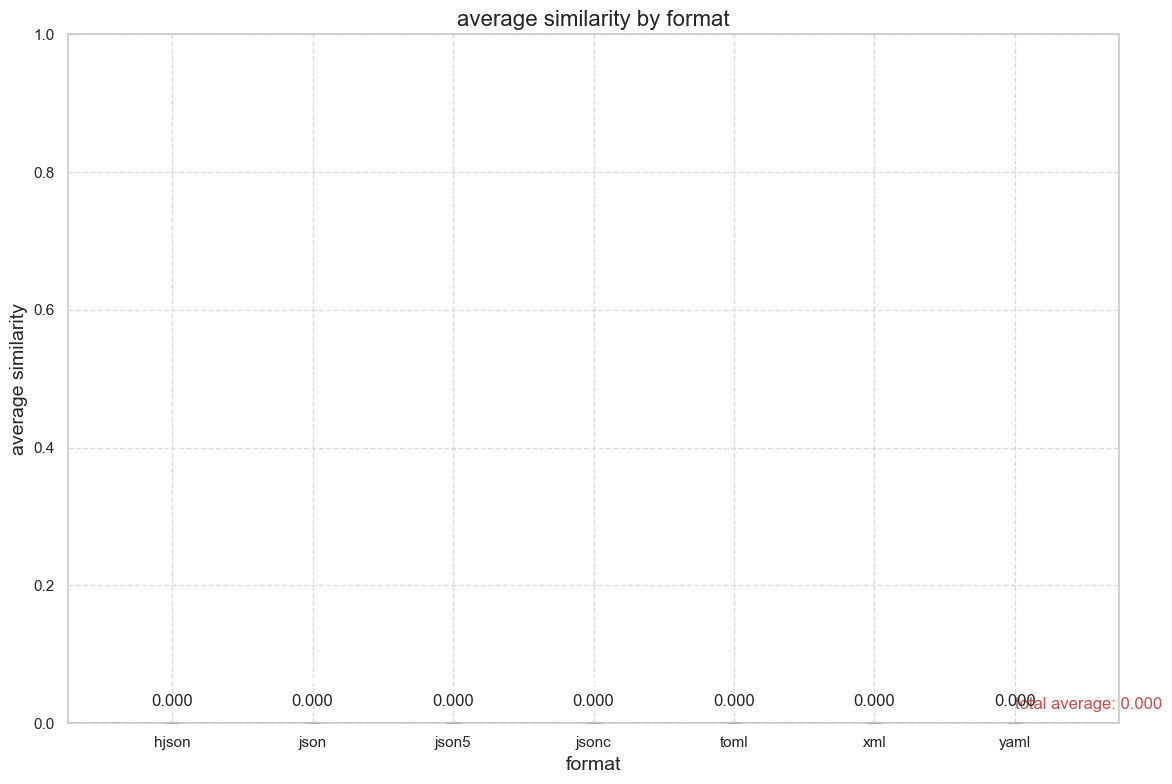

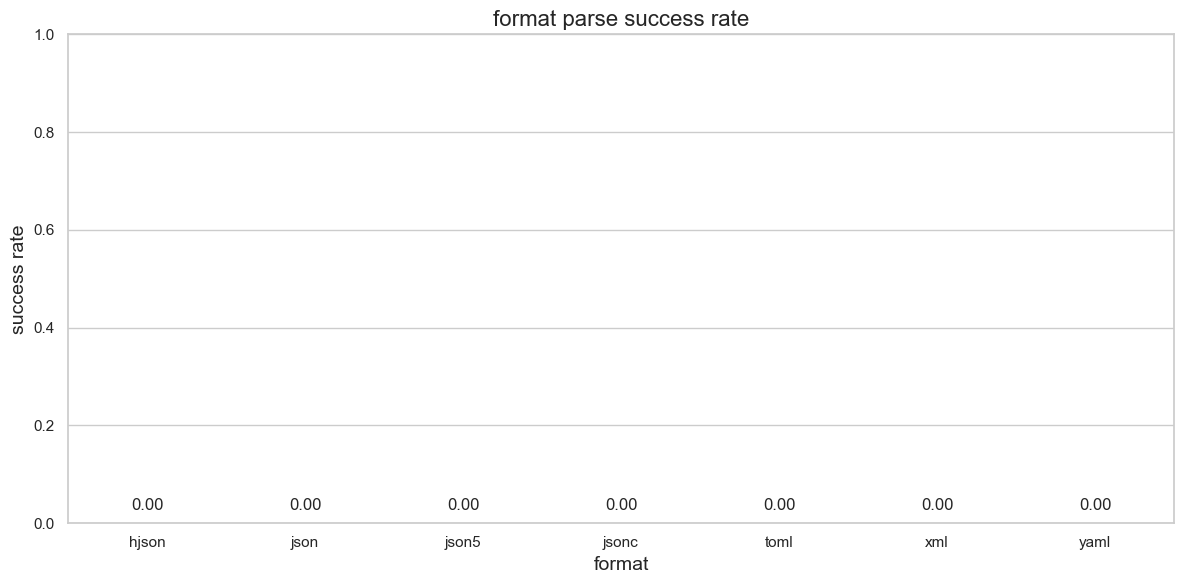

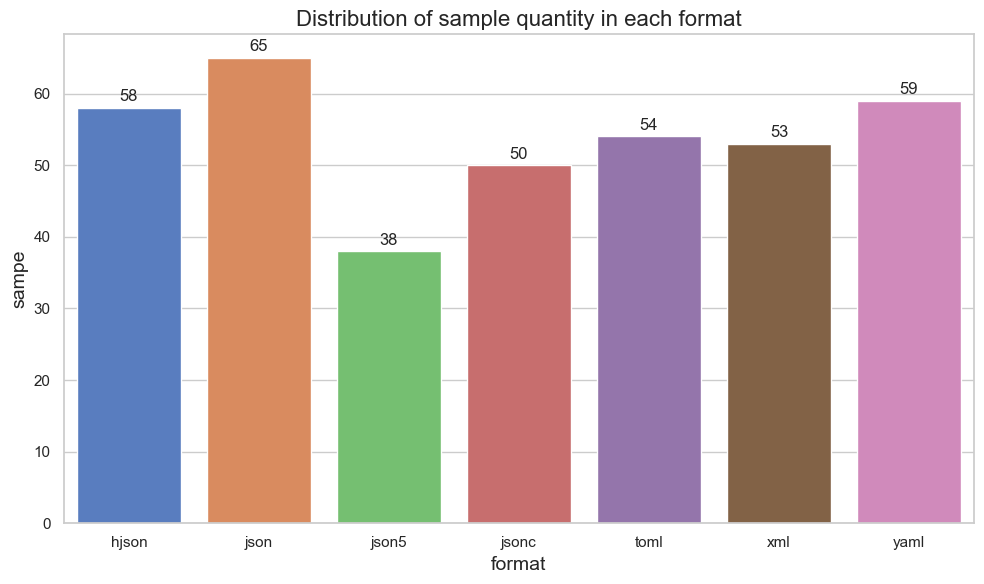

,similarity_score_mean,similarity_score_std,similarity_score_count,similarity_score_min,similarity_score_max,normalized_ted_mean,normalized_ted_std,normalized_ted_min,normalized_ted_max,error_<lambda>,success_rate
format,,,,,,,,,,,
hjson,0.0,0.0,58,0.0,0.0,1.0,0.0,1.0,1.0,58,0.0
json,0.0,0.0,65,0.0,0.0,1.0,0.0,1.0,1.0,65,0.0
json5,0.0,0.0,38,0.0,0.0,1.0,0.0,1.0,1.0,38,0.0
jsonc,0.0,0.0,50,0.0,0.0,1.0,0.0,1.0,1.0,50,0.0
toml,0.0,0.0,54,0.0,0.0,1.0,0.0,1.0,1.0,54,0.0
xml,0.0,0.0,53,0.0,0.0,1.0,0.0,1.0,1.0,53,0.0
yaml,0.0,0.0,59,0.0,0.0,1.0,0.0,1.0,1.0,59,0.0


In [16]:
import pandas as pd
import re
from linter import compare_structures_tree_edit_distance


# ✨ 四个 task 使用同一个 gold 对象
vega_lite_config = {
    "name": "vega-lite",
    "author": "Dominik Moritz, Kanit Wongsuphasawat, Arvind Satyanarayan, Jeffrey Heer",
    "version": "5.23.0",
    "collaborators": [
        "Kanit Wongsuphasawat",
        "Dominik Moritz",
        "Arvind Satyanarayan",
        "Jeffrey Heer"
    ],
    "homepage": "vega.github.io/vega-lite/",
    "description": "Vega-Lite is a concise high-level language for interactive visualization.",
    "keywords": ["vega", "chart", "visualization"],
    "main": "build/vega-lite.js",
    "unpkg": "build/vega-lite.min.js",
    "jsdelivr": "build/vega-lite.min.js",
    "module": "build/src/index",
    "types": "build/src/index.d.ts",
    "bin": {
        "vl2pdf": "./bin/vl2pdf",
        "vl2png": "./bin/vl2png",
        "vl2svg": "./bin/vl2svg",
        "vl2vg": "./bin/vl2vg"
    },
    "files": ["bin", "build", "src", "vega-lite*", "tsconfig.json"],
    "scripts": {
        "changelog": "conventional-changelog -p angular -r",
        "prebuild": "yarn clean:build",
        "build": "yarn build:only",
        "data": "rsync -r node_modules/vega-datasets/data/* site/data",
        "build-editor-preview": "scripts/build-editor-preview.sh",
        "schema": "mkdir -p build && ts-json-schema-generator -f tsconfig.json -p src/index.ts -t TopLevelSpec --no-type-check --no-ref-encode > build/vega-lite-schema.json && yarn renameschema && cp build/vega-lite-schema.json site/_data/",
        "renameschema": "scripts/rename-schema.sh",
        "presite": "yarn data && yarn schema && yarn build:site && yarn build:versions && scripts/create-example-pages.sh",
        "site": "yarn site:only",
        "format": "eslint . --fix && yarn prettierbase --write",
        "lint": "eslint . && yarn prettierbase --check",
        "test": "yarn jest test/ && yarn lint && yarn schema && yarn jest examples/ && yarn",
        "release": "release-it"
    },
    "repository": {
        "type": "git",
        "url": "github.com/vega/vega-lite.git"
    },
    "license": "BSD-3-Clause",
    "bugs": {
        "url": "github.com/vega/vega-lite/issues"
    },
    "peerDependencies": {
        "vega": "^5.31.0"
    },
    "engines": {
        "node": ">=18"
    },
    "packageManager": "yarn@1.22.22"
}

# ✨ 四个 task 都映射到这个结构
correct_data_dict = {
    f"modifying-task-tabular-{i}": vega_lite_config
    for i in range(1, 5)
}


# ✅ 主函数：每个 modifying task 使用不同 gold 数据执行结构比对
import pandas as pd
import re
from linter import serialize_correct_tabular_data, compare_structures_tree_edit_distance

def compare_structures_tree_edit_distance_modifying(user_code, gold_data_dict, task_key, fmt_user, fmt_gold="json"):
    """
    针对 modifying-task-tabular-<n>，选择正确的 gold 结构进行结构比较。
    """
    result = {
        "ted": None,
        "normalized_ted": 1.0,
        "similarity_score": 0.0,
        "tree_size1": None,
        "tree_size2": None,
        "error": "init"
    }

    try:
        if task_key not in gold_data_dict:
            result["error"] = f"Missing gold for task {task_key}"
            return result

        gold_data = gold_data_dict[task_key]
        gold_code = serialize_correct_tabular_data(gold_data, fmt_gold)

        diff = compare_structures_tree_edit_distance(
            gold_code, user_code,
            fmt1=fmt_gold,
            fmt2=fmt_user
        )

        result.update(diff)
        result["error"] = ""
        return result

    except Exception as e:
        result["error"] = str(e)
        return result

import re
import pandas as pd
from linter import compare_structures_tree_edit_distance

def batch_tree_distance_analysis_tree_only_modifying(all_data, correct_data_dict, gold_format="json"):
    results = []

    for file_name, quiz_data in all_data.items():
        answers = quiz_data.get('answers', {})

        # 获取 participantId
        participant_id = file_name
        for v in answers.values():
            if isinstance(v, dict):
                a = v.get("answer", {})
                if isinstance(a, dict) and "prolificId" in a:
                    participant_id = a["prolificId"]
                    break

        # 检测格式
        format_name = None
        for k in answers:
            m = re.match(r"tutorial-(\w+)-part1", k)
            if m:
                format_name = m.group(1).lower()
                break
        if not format_name:
            for k in answers:
                if "modifying-task-tabular-" in k:
                    parts = k.replace("modifying-task-tabular-", "").split("-")
                    if parts:
                        format_name = parts[0].lower()
                        break
        if not format_name:
            format_name = "unknown"

        # 遍历每个 modifying-task
        for key, content in answers.items():
            if key.startswith("modifying-task-tabular-") and isinstance(content, dict):
                ans_block = content.get("answer", {})
                code = ans_block.get("code") if isinstance(ans_block, dict) else None
                if not code:
                    continue

                # 正确提取 task id 并构造 gold key
                match = re.match(r"modifying-task-tabular-\w+-(\d+)$", key)
                if match:
                    task_number = match.group(1)
                    gold_key = f"modifying-task-tabular-{task_number}"
                    gold = correct_data_dict.get(gold_key)
                else:
                    gold = None

                if gold is None:
                    results.append({
                        "participantId": participant_id,
                        "format": format_name,
                        "task": key,
                        "ted": None,
                        "normalized_ted": 1.0,
                        "similarity_score": 0.0,
                        "gold_tree_size": None,
                        "user_tree_size": None,
                        "error": f"Missing gold for task {key}"
                    })
                    continue

                try:
                    result = compare_structures_tree_edit_distance(
                        gold, code,
                        fmt1=gold_format,
                        fmt2=format_name
                    )
                    results.append({
                        "participantId": participant_id,
                        "format": format_name,
                        "task": key,
                        "ted": result.get("ted"),
                        "normalized_ted": result.get("normalized_ted"),
                        "similarity_score": result.get("similarity_score"),
                        "gold_tree_size": result.get("tree_size1"),
                        "user_tree_size": result.get("tree_size2"),
                        "error": result.get("error", "")
                    })
                except Exception as e:
                    results.append({
                        "participantId": participant_id,
                        "format": format_name,
                        "task": key,
                        "ted": None,
                        "normalized_ted": 1.0,
                        "similarity_score": 0.0,
                        "gold_tree_size": None,
                        "user_tree_size": None,
                        "error": f"TED failed: {e}"
                    })

    return pd.DataFrame(results)



from linter import calculate_format_similarity_stats, visualize_format_similarity

# 执行结构相似度分析
df_ted_modifying = batch_tree_distance_analysis_tree_only_modifying(
    all_data,
    correct_data_dict=correct_data_dict,
    gold_format="json"
)


df_stats_mod = calculate_format_similarity_stats(df_ted_modifying)

# 绘图展示
visualize_format_similarity(df_stats_mod)

# 返回统计表
df_stats_mod



In [17]:
df_ted_modifying

,participantId,format,task,ted,normalized_ted,similarity_score,gold_tree_size,user_tree_size,error
0,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-1,None,1.0,0.0,None,None,解析失败 (json/hjson): Invalid code string: <class...
1,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-2,None,1.0,0.0,None,None,解析失败 (json/hjson): Invalid code string: <class...
2,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-4,None,1.0,0.0,None,None,解析失败 (json/hjson): Invalid code string: <class...
3,67e25388d573ec2d5f1c8442,yaml,modifying-task-tabular-yaml-1,None,1.0,0.0,None,None,解析失败 (json/yaml): Invalid code string: <class ...
4,67e25388d573ec2d5f1c8442,yaml,modifying-task-tabular-yaml-2,None,1.0,0.0,None,None,解析失败 (json/yaml): Invalid code string: <class ...
...,...,...,...,...,...,...,...,...,...
372,67adb27bd5f5776fcb16da62,hjson,modifying-task-tabular-hjson-4,None,1.0,0.0,None,None,解析失败 (json/hjson): Invalid code string: <class...
373,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-hjson-1,None,1.0,0.0,None,None,解析失败 (json/hjson): Invalid code string: <class...
374,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-hjson-2,None,1.0,0.0,None,None,解析失败 (json/hjson): Invalid code string: <class...
375,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-hjson-3,None,1.0,0.0,None,None,解析失败 (json/hjson): Invalid code string: <class...


In [13]:
def compare_structures_tree_edit_distance_modifying(user_code, gold_data_dict, task_key, fmt_user, fmt_gold="json"):
    """
    针对 modifying-task-tabular-<n> 结构，选择对应的标准 JSON 进行 Tree Edit Distance 比较。
    
    参数:
      user_code     字符串，用户的 JSON 代码
      gold_data_dict 字典，key 为 task（如 "modifying-task-tabular-1"），value 为标准 JSON 数据结构
      task_key      当前的任务键名（如 "modifying-task-tabular-1"）
      fmt_user      用户使用的格式（如 json, toml 等）
      fmt_gold      标准答案的格式，默认为 json

    返回:
      dict，包括 ted, normalized_ted, similarity_score, tree_size1, tree_size2, error
    """
    from linter import serialize_correct_tabular_data, compare_structures_tree_edit_distance

    result = {
        "ted": None,
        "normalized_ted": 1.0,
        "similarity_score": 0.0,
        "tree_size1": None,
        "tree_size2": None,
        "error": "init"
    }

    try:
        # 获取对应标准答案
        base_task_key = re.sub(r"-\w+-(\d+)$", r"-\1", task_key)

        if base_task_key not in gold_data_dict:
            result["error"] = f"Missing gold for task {base_task_key}"
            return result

        gold_data = gold_data_dict[base_task_key]
        gold_code = serialize_correct_tabular_data(gold_data, fmt_gold)

        # 比较结构
        diff = compare_structures_tree_edit_distance(
            gold_code,
            user_code,
            fmt1=fmt_gold,
            fmt2=fmt_user
        )

        result.update(diff)
        result["error"] = ""
        return result

    except Exception as e:
        result["error"] = str(e)
        return result


In [18]:
import re
import json
import hjson
import pandas as pd
from linter import serialize_correct_tabular_data, compare_structures_tree_edit_distance

def batch_tree_distance_analysis_tree_only_modifying(
    all_data: dict,
    correct_data_dict: dict,
    gold_format: str = "json"
) -> pd.DataFrame:
    """
    对 modifying-task-tabular-1 至 4 中的用户答案，分别与 correct_data_dict
    中对应的标准 JSON 进行结构相似度 (Tree Edit Distance) 分析。

    all_data:      Prolific 返回的原始数据字典
    correct_data_dict: dict, key 为 "modifying-task-tabular-<n>"，value 为标准 JSON obj
    gold_format:   标准答案的格式 (“json”)

    返回 DataFrame 包含列：
      participantId, format, task, ted, normalized_ted,
      similarity_score, gold_tree_size, user_tree_size, error
    """
    results = []

    for file_name, quiz_data in all_data.items():
        answers = quiz_data.get("answers", {})

        # 1) 找 participantId
        pid = file_name
        for info in answers.values():
            if isinstance(info, dict):
                ans = info.get("answer", {})
                if isinstance(ans, dict) and "prolificId" in ans:
                    pid = ans["prolificId"]
                    break

        # 2) 推断用户 format
        fmt_user = None
        for k in answers:
            m = re.match(r"tutorial-(\w+)-part1", k)
            if m:
                fmt_user = m.group(1).lower()
                break
        if not fmt_user:
            for k in answers:
                if k.startswith("modifying-task-tabular-"):
                    parts = k.split("-")
                    if len(parts) >= 4:
                        fmt_user = parts[3].lower()
                        break
        if not fmt_user:
            fmt_user = "unknown"

        # 3) 遍历所有 modifying-task-tabular-*
        for task_key, content in answers.items():
            if not task_key.startswith("modifying-task-tabular-"):
                continue
            if not isinstance(content, dict):
                continue

            # 3a) 获得用户代码
            ansb = content.get("answer", {}) or {}
            user_code_raw = ansb.get("code")
            if not isinstance(user_code_raw, str) or not user_code_raw.strip():
                # 跳过空代码
                results.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": None,
                    "normalized_ted": 1.0,
                    "similarity_score": 0.0,
                    "gold_tree_size": None,
                    "user_tree_size": None,
                    "error": "Empty or missing code"
                })
                continue

            # 3b) 解析成 JSON 字符串，支持 json 和 hjson
            try:
                if fmt_user in ("hjson",):
                    obj = hjson.loads(user_code_raw)
                else:
                    obj = json.loads(user_code_raw)
                user_code = json.dumps(obj, indent=2)
            except Exception as e:
                results.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": None,
                    "normalized_ted": 1.0,
                    "similarity_score": 0.0,
                    "gold_tree_size": None,
                    "user_tree_size": None,
                    "error": f"Parse user code failed ({fmt_user}): {e}"
                })
                continue

            # 3c) 提取标准答案 key（去掉中间格式段）
            m = re.match(r"^(modifying-task-tabular)-\w+-(\d+)$", task_key)
            if not m:
                results.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": None,
                    "normalized_ted": 1.0,
                    "similarity_score": 0.0,
                    "gold_tree_size": None,
                    "user_tree_size": None,
                    "error": f"Invalid task key"
                })
                continue
            base_key = f"{m.group(1)}-{m.group(2)}"
            gold_json_obj = correct_data_dict.get(base_key)
            if gold_json_obj is None:
                results.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": None,
                    "normalized_ted": 1.0,
                    "similarity_score": 0.0,
                    "gold_tree_size": None,
                    "user_tree_size": None,
                    "error": f"Missing gold for {base_key}"
                })
                continue

            # 3d) 将 gold_obj 序列化为标准代码字符串
            gold_code = serialize_correct_tabular_data(gold_json_obj, gold_format)

            # 3e) 进行 Tree Edit Distance 比较
            try:
                diff = compare_structures_tree_edit_distance(
                    gold_code, user_code,
                    fmt1=gold_format, fmt2=fmt_user
                )
                results.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": diff.get("ted"),
                    "normalized_ted": diff.get("normalized_ted"),
                    "similarity_score": diff.get("similarity_score"),
                    "gold_tree_size": diff.get("tree_size1"),
                    "user_tree_size": diff.get("tree_size2"),
                    "error": diff.get("error", "")
                })
            except Exception as e:
                results.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": None,
                    "normalized_ted": 1.0,
                    "similarity_score": 0.0,
                    "gold_tree_size": None,
                    "user_tree_size": None,
                    "error": f"TED failed: {e}"
                })

    return pd.DataFrame(results)


from linter import calculate_format_similarity_stats, visualize_format_similarity

# 四个任务都用同一个标准答案
correct_data_dict = {
    f"modifying-task-tabular-{i}": vega_lite_config
    for i in range(1, 5)
}

df_ted_mod = batch_tree_distance_analysis_tree_only_modifying(
    all_data,
    correct_data_dict=correct_data_dict,
    gold_format="json"
)

# 统计 & 可视化
df_stats_mod = calculate_format_similarity_stats(df_ted_mod)
visualize_format_similarity(df_stats_mod)

df_stats_mod  # 查看统计结果



KeyboardInterrupt: 

In [ ]:
import re
import json
import hjson
import pandas as pd
from linter import compare_structures_tree_edit_distance, detect_format


def batch_tree_distance_analysis_tree_only(all_data, gold_struct_data):
    """
    通过树编辑距离批量比较用户答案与标准答案的结构相似度。
    
    - 如果 gold_struct_data 是单个 dict，就只处理 writing-task-tabular-*，使用同一个标准答案。
    - 如果 gold_struct_data 是 mapping（键为 modifying-task-tabular-1...4），
      就只处理 modifying-task-tabular-*，并按编号选对应标准答案。
    """
    # 判断是不是 modifying 映射模式
    is_mod_mapping = (
        isinstance(gold_struct_data, dict)
        and all(k.startswith("modifying-task-tabular-") for k in gold_struct_data)
    )
    # 如果不是映射模式，就把单一 dict 序列化一份
    if not is_mod_mapping:
        gold_code_single = json.dumps(gold_struct_data, indent=2, sort_keys=True)

    rows = []
    for fn, quiz in all_data.items():
        answers = quiz.get("answers", {})

        # --- 1) participantId ---
        pid = fn
        for info in answers.values():
            if isinstance(info, dict):
                ans = info.get("answer", {})
                if isinstance(ans, dict) and "prolificId" in ans:
                    pid = ans["prolificId"]
                    break

        # --- 2) 用户 format 推断 ---
        fmt_user = None
        for k in answers:
            m = re.match(r"tutorial-([^-]+)-part1", k)
            if m:
                fmt_user = m.group(1).lower()
                break
        if not fmt_user:
            for k in answers:
                if k.startswith("writing-task-tabular-") or k.startswith("modifying-task-tabular-"):
                    fmt_user = k.split("-")[3].lower()
                    break
        if not fmt_user:
            fmt_user = "unknown"

        # --- 3) 处理任务 ---
        for task_key, content in answers.items():
            if not isinstance(content, dict):
                continue

            # 映射模式：只处理 modifying-task-tabular-*
            if is_mod_mapping:
                if not task_key.startswith("modifying-task-tabular-"):
                    continue
            # 非映射模式：只处理 writing-task-tabular-*
            else:
                if not task_key.startswith("writing-task-tabular-"):
                    continue

            # 跳过后置问卷
            if "_post-task-question" in task_key:
                continue

            # --- 3a) 用户代码 ---
            ansb = content.get("answer", {}) or {}
            code_raw = ansb.get("code")
            if not isinstance(code_raw, str) or not code_raw.strip():
                continue

            # --- 3b) 解析为标准 JSON 字符串 ---
            try:
                if fmt_user == "hjson":
                    obj = hjson.loads(code_raw)
                else:
                    obj = json.loads(code_raw)
                user_code = json.dumps(obj, indent=2, sort_keys=True)
            except Exception as e:
                rows.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": None,
                    "normalized_ted": 1.0,
                    "similarity_score": 0.0,
                    "gold_tree_size": None,
                    "user_tree_size": None,
                    "error": f"Parse user code failed ({fmt_user}): {e}"
                })
                continue

            # --- 3c) 选取标准答案 ---
            if is_mod_mapping:
                # extracting number
                m = re.match(r"modifying-task-tabular-\w+-(\d+)$", task_key)
                if not m:
                    continue
                base = f"modifying-task-tabular-{m.group(1)}"
                gold_obj = gold_struct_data.get(base)
                if gold_obj is None:
                    rows.append({
                        "participantId": pid,
                        "format": fmt_user,
                        "task": task_key,
                        "ted": None,
                        "normalized_ted": 1.0,
                        "similarity_score": 0.0,
                        "gold_tree_size": None,
                        "user_tree_size": None,
                        "error": f"Missing gold for {base}"
                    })
                    continue
                gold_code = json.dumps(gold_obj, indent=2, sort_keys=True)
            else:
                gold_code = gold_code_single

            # --- 3d) Tree Edit Distance ---
            try:
                diff = compare_structures_tree_edit_distance(
                    gold_code, user_code,
                    fmt1="json", fmt2=fmt_user
                )
                rows.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": diff.get("ted"),
                    "normalized_ted": diff.get("normalized_ted"),
                    "similarity_score": diff.get("similarity_score"),
                    "gold_tree_size": diff.get("tree_size1"),
                    "user_tree_size": diff.get("tree_size2"),
                    "error": diff.get("error", "")
                })
            except Exception as e:
                rows.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": None,
                    "normalized_ted": 1.0,
                    "similarity_score": 0.0,
                    "gold_tree_size": None,
                    "user_tree_size": None,
                    "error": f"TED failed: {e}"
                })

    return pd.DataFrame(rows)


from linter import calculate_format_similarity_stats, visualize_format_similarity

correct_data_dict = {
    f"modifying-task-tabular-{i}": vega_lite_config
    for i in range(1, 5)
}
df_ted_mod = batch_tree_distance_analysis_tree_only(all_data, correct_data_dict)
df_stats_m = calculate_format_similarity_stats(df_ted_mod)
visualize_format_similarity(df_stats_m)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7feed0fc46d0>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
import re
import json
import hjson
import pandas as pd
from tqdm import tqdm
from linter import compare_structures_tree_edit_distance, detect_format, serialize_correct_tabular_data

def batch_tree_distance_analysis(
    all_data: dict,
    gold_struct_data,
    mode: str = "writing",
    gold_format: str = "json",
    show_progress: bool = True
) -> pd.DataFrame:
    """
    通过树编辑距离批量比较用户答案与标准答案的结构相似度。

    Args:
      all_data:         Prolific 导出的全部答题记录 dict
      gold_struct_data: 如果 mode=="writing"，则为单个标准 JSON dict；
                        如果 mode=="modifying"，则为 { "modifying-task-tabular-1": json1, … } 映射。
      mode:             "writing" 或 "modifying"
      gold_format:      标准答案格式（默认 "json"）
      show_progress:    是否显示 tqdm 进度条

    Returns:
      pandas.DataFrame: 每行包含 participantId, format, task, ted, normalized_ted,
                        similarity_score, gold_tree_size, user_tree_size, error
    """
    is_mod = (mode.lower() == "modifying")
    if not is_mod:
        # writing 模式：序列化单一 gold
        gold_code_single = json.dumps(gold_struct_data, indent=2, sort_keys=True)

    rows = []
    iterator = tqdm(all_data.items(), desc="Processing tasks", disable=not show_progress)
    for fn, quiz in iterator:
        answers = quiz.get("answers", {})

        # 1) participantId
        pid = fn
        for info in answers.values():
            if isinstance(info, dict):
                a = info.get("answer", {})
                if isinstance(a, dict) and "prolificId" in a:
                    pid = a["prolificId"]
                    break

        # 2) 推断用户 format
        fmt_user = None
        for key in answers:
            m = re.match(r"tutorial-([^-]+)-part1", key)
            if m:
                fmt_user = m.group(1).lower()
                break
        if not fmt_user:
            for key in answers:
                prefix = "writing-task-tabular-" if not is_mod else "modifying-task-tabular-"
                if key.startswith(prefix):
                    parts = key.split("-")
                    if len(parts) >= 4:
                        fmt_user = parts[3].lower()
                        break
        fmt_user = fmt_user or "unknown"

        # 3) 遍历任务
        for task_key, content in answers.items():
            if not isinstance(content, dict):
                continue
            if is_mod:
                if not task_key.startswith("modifying-task-tabular-"):
                    continue
            else:
                if not task_key.startswith("writing-task-tabular-"):
                    continue
            if "_post-task-question" in task_key:
                continue

            # 3a) 提取用户代码
            ansb = content.get("answer", {}) or {}
            code_raw = ansb.get("code")
            if not isinstance(code_raw, str) or not code_raw.strip():
                continue

            # 3b) 解析为规范 JSON 字符串
            try:
                obj = hjson.loads(code_raw) if fmt_user == "hjson" else json.loads(code_raw)
                user_code = json.dumps(obj, indent=2, sort_keys=True)
            except Exception as e:
                rows.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": None,
                    "normalized_ted": 1.0,
                    "similarity_score": 0.0,
                    "gold_tree_size": None,
                    "user_tree_size": None,
                    "error": f"Parse user code failed ({fmt_user}): {e}"
                })
                continue

            # 3c) 选取 gold_code
            if is_mod:
                m = re.match(r"^modifying-task-tabular-\w+-(\d+)$", task_key)
                if not m:
                    continue
                base = f"modifying-task-tabular-{m.group(1)}"
                gold_obj = gold_struct_data.get(base)
                if gold_obj is None:
                    rows.append({
                        "participantId": pid,
                        "format": fmt_user,
                        "task": task_key,
                        "ted": None,
                        "normalized_ted": 1.0,
                        "similarity_score": 0.0,
                        "gold_tree_size": None,
                        "user_tree_size": None,
                        "error": f"Missing gold for {base}"
                    })
                    continue
                gold_code = serialize_correct_tabular_data(gold_obj, gold_format)
            else:
                gold_code = gold_code_single

            # 3d) 执行结构比较
            try:
                diff = compare_structures_tree_edit_distance(
                    gold_code, user_code,
                    fmt1=gold_format, fmt2=fmt_user
                )
                rows.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": diff.get("ted"),
                    "normalized_ted": diff.get("normalized_ted"),
                    "similarity_score": diff.get("similarity_score"),
                    "gold_tree_size": diff.get("tree_size1"),
                    "user_tree_size": diff.get("tree_size2"),
                    "error": diff.get("error", "")
                })
            except Exception as e:
                rows.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": task_key,
                    "ted": None,
                    "normalized_ted": 1.0,
                    "similarity_score": 0.0,
                    "gold_tree_size": None,
                    "user_tree_size": None,
                    "error": f"TED failed: {e}"
                })

    return pd.DataFrame(rows)

from linter import calculate_format_similarity_stats, visualize_format_similarity

# # 写作任务
# df_w = batch_tree_distance_analysis(all_data, correct_tabular_data, mode="writing")
# df_stats_w = calculate_format_similarity_stats(df_w)
# visualize_format_similarity(df_stats_w)
vega_lite_config = {
    "name": "vega-lite",
    "author": "Dominik Moritz, Kanit Wongsuphasawat, Arvind Satyanarayan, Jeffrey Heer",
    "version": "5.23.0",
    "collaborators": [
        "Kanit Wongsuphasawat",
        "Dominik Moritz",
        "Arvind Satyanarayan",
        "Jeffrey Heer"
    ],
    "homepage": "vega.github.io/vega-lite/",
    "description": "Vega-Lite is a concise high-level language for interactive visualization.",
    "keywords": ["vega", "chart", "visualization"],
    "main": "build/vega-lite.js",
    "unpkg": "build/vega-lite.min.js",
    "jsdelivr": "build/vega-lite.min.js",
    "module": "build/src/index",
    "types": "build/src/index.d.ts",
    "bin": {
        "vl2pdf": "./bin/vl2pdf",
        "vl2png": "./bin/vl2png",
        "vl2svg": "./bin/vl2svg",
        "vl2vg": "./bin/vl2vg"
    },
    "files": ["bin", "build", "src", "vega-lite*", "tsconfig.json"],
    "scripts": {
        "changelog": "conventional-changelog -p angular -r",
        "prebuild": "yarn clean:build",
        "build": "yarn build:only",
        "data": "rsync -r node_modules/vega-datasets/data/* site/data",
        "build-editor-preview": "scripts/build-editor-preview.sh",
        "schema": "mkdir -p build && ts-json-schema-generator -f tsconfig.json -p src/index.ts -t TopLevelSpec --no-type-check --no-ref-encode > build/vega-lite-schema.json && yarn renameschema && cp build/vega-lite-schema.json site/_data/",
        "renameschema": "scripts/rename-schema.sh",
        "presite": "yarn data && yarn schema && yarn build:site && yarn build:versions && scripts/create-example-pages.sh",
        "site": "yarn site:only",
        "format": "eslint . --fix && yarn prettierbase --write",
        "lint": "eslint . && yarn prettierbase --check",
        "test": "yarn jest test/ && yarn lint && yarn schema && yarn jest examples/ && yarn",
        "release": "release-it"
    },
    "repository": {
        "type": "git",
        "url": "github.com/vega/vega-lite.git"
    },
    "license": "BSD-3-Clause",
    "bugs": {
        "url": "github.com/vega/vega-lite/issues"
    },
    "peerDependencies": {
        "vega": "^5.31.0"
    },
    "engines": {
        "node": ">=18"
    },
    "packageManager": "yarn@1.22.22"
}

# ✨ 四个 task 都映射到这个结构
correct_data_dict = {
    f"modifying-task-tabular-{i}": vega_lite_config
    for i in range(1, 5)
}

df_m = batch_tree_distance_analysis(all_data, correct_data_dict, mode="modifying")
df_stats_m = calculate_format_similarity_stats(df_m)
visualize_format_similarity(df_stats_m)

/opt/anaconda3/lib/python3.8/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
Processing tasks:   0%|          | 0/107 [00:00<?, ?it/s]Error processing line 1 of /opt/anaconda3/lib/python3.8/site-packages/prose-datainsights-nspkg.pth:

  Traceback (most recent call last):
    File "/opt/anaconda3/lib/python3.8/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 553, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


In [ ]:
import re
import json
import hjson
import pandas as pd
from tqdm import tqdm
from linter import compare_structures_tree_edit_distance, serialize_correct_tabular_data, detect_format

def batch_tree_distance_analysis_fast(
    all_data: dict,
    gold_struct_data,
    mode: str = "writing",
    gold_format: str = "json",
    show_progress: bool = True
) -> pd.DataFrame:
    """
    分两阶段走，显著提速：
      1) 扫一遍 all_data，只做最小 code 解析，收集 valid 项
      2) 预先序列化金标准（单一或 mapping），再对收集到的 items 做 TED 比较

    Args:
      all_data:         全部答题记录
      gold_struct_data: 写作模式 -> 单个标准 JSON dict；
                        修改模式 -> { "modifying-task-tabular-1": json1, … } 映射
      mode:             "writing" 或 "modifying"
      gold_format:      标准答案格式
      show_progress:    是否显示 tqdm 进度条

    Returns:
      DataFrame 每行 participantId, format, task, ted, normalized_ted,
                similarity_score, gold_tree_size, user_tree_size, error
    """
    is_mod = (mode.lower() == "modifying")

    # 1) 收集所有待比较项（先解析用户代码）
    items = []
    for fn, quiz in all_data.items():
        answers = quiz.get("answers", {})
        # extract participantId
        pid = fn
        for v in answers.values():
            if isinstance(v, dict):
                a = v.get("answer", {}) or {}
                if isinstance(a, dict) and "prolificId" in a:
                    pid = a["prolificId"]
                    break

        # detect user format
        fmt_user = None
        for k in answers:
            m = re.match(r"tutorial-([^-]+)-part1", k)
            if m:
                fmt_user = m.group(1).lower()
                break
        if not fmt_user:
            for k in answers:
                prefix = "modifying-task-tabular-" if is_mod else "writing-task-tabular-"
                if k.startswith(prefix):
                    parts = k.split("-")
                    if len(parts) >= 4:
                        fmt_user = parts[3].lower()
                        break
        fmt_user = fmt_user or "unknown"

        # scan tasks
        for key, content in answers.items():
            if not isinstance(content, dict):
                continue
            if is_mod and not key.startswith("modifying-task-tabular-"):
                continue
            if not is_mod and not key.startswith("writing-task-tabular-"):
                continue
            if "_post-task-question" in key:
                continue

            ansb = content.get("answer", {}) or {}
            code_raw = ansb.get("code")
            if not isinstance(code_raw, str) or not code_raw.strip():
                continue

            # try parse
            try:
                parsed = hjson.loads(code_raw) if fmt_user=="hjson" else json.loads(code_raw)
                user_code = json.dumps(parsed, indent=2, sort_keys=True)
            except Exception as e:
                items.append({
                    "participantId": pid,
                    "format": fmt_user,
                    "task": key,
                    "user_code": None,
                    "error": f"Parse user code failed ({fmt_user}): {e}"
                })
                continue

            items.append({
                "participantId": pid,
                "format": fmt_user,
                "task": key,
                "user_code": user_code,
                "error": ""
            })

    # 2) 预序列化标准答案
    if not is_mod:
        gold_code_single = json.dumps(gold_struct_data, indent=2, sort_keys=True)
    else:
        gold_code_map = {}
        for tk, obj in gold_struct_data.items():
            gold_code_map[tk] = serialize_correct_tabular_data(obj, gold_format)

    # 3) 对收集到的 items 做比较
    rows = []
    iterator = items if not show_progress else tqdm(items, desc="Comparing", unit="item")
    for it in iterator:
        pid = it["participantId"]
        fmt_user = it["format"]
        task_key = it["task"]
        user_code = it["user_code"]
        err = it["error"]
        if err:
            rows.append({
                "participantId": pid, "format": fmt_user, "task": task_key,
                "ted": None, "normalized_ted": 1.0, "similarity_score": 0.0,
                "gold_tree_size": None, "user_tree_size": None, "error": err
            })
            continue

        # select gold_code
        if not is_mod:
            gold_code = gold_code_single
        else:
            m = re.match(r"^modifying-task-tabular-\w+-(\d+)$", task_key)
            if not m:
                rows.append({
                    "participantId": pid, "format": fmt_user, "task": task_key,
                    "ted": None, "normalized_ted": 1.0, "similarity_score": 0.0,
                    "gold_tree_size": None, "user_tree_size": None,
                    "error": "Invalid task key"
                })
                continue
            base = f"modifying-task-tabular-{m.group(1)}"
            gold_code = gold_code_map.get(base)
            if gold_code is None:
                rows.append({
                    "participantId": pid, "format": fmt_user, "task": task_key,
                    "ted": None, "normalized_ted": 1.0, "similarity_score": 0.0,
                    "gold_tree_size": None, "user_tree_size": None,
                    "error": f"Missing gold for {base}"
                })
                continue

        # compare
        try:
            diff = compare_structures_tree_edit_distance(
                gold_code, user_code, fmt1=gold_format, fmt2=fmt_user
            )
            rows.append({
                "participantId": pid,
                "format": fmt_user,
                "task": task_key,
                "ted": diff.get("ted"),
                "normalized_ted": diff.get("normalized_ted"),
                "similarity_score": diff.get("similarity_score"),
                "gold_tree_size": diff.get("tree_size1"),
                "user_tree_size": diff.get("tree_size2"),
                "error": diff.get("error", "")
            })
        except Exception as e:
            rows.append({
                "participantId": pid,
                "format": fmt_user,
                "task": task_key,
                "ted": None,
                "normalized_ted": 1.0,
                "similarity_score": 0.0,
                "gold_tree_size": None,
                "user_tree_size": None,
                "error": f"TED failed: {e}"
            })

    return pd.DataFrame(rows)


vega_lite_config = {
    "name": "vega-lite",
    "author": "Dominik Moritz, Kanit Wongsuphasawat, Arvind Satyanarayan, Jeffrey Heer",
    "version": "5.23.0",
    "collaborators": [
        "Kanit Wongsuphasawat",
        "Dominik Moritz",
        "Arvind Satyanarayan",
        "Jeffrey Heer"
    ],
    "homepage": "vega.github.io/vega-lite/",
    "description": "Vega-Lite is a concise high-level language for interactive visualization.",
    "keywords": ["vega", "chart", "visualization"],
    "main": "build/vega-lite.js",
    "unpkg": "build/vega-lite.min.js",
    "jsdelivr": "build/vega-lite.min.js",
    "module": "build/src/index",
    "types": "build/src/index.d.ts",
    "bin": {
        "vl2pdf": "./bin/vl2pdf",
        "vl2png": "./bin/vl2png",
        "vl2svg": "./bin/vl2svg",
        "vl2vg": "./bin/vl2vg"
    },
    "files": ["bin", "build", "src", "vega-lite*", "tsconfig.json"],
    "scripts": {
        "changelog": "conventional-changelog -p angular -r",
        "prebuild": "yarn clean:build",
        "build": "yarn build:only",
        "data": "rsync -r node_modules/vega-datasets/data/* site/data",
        "build-editor-preview": "scripts/build-editor-preview.sh",
        "schema": "mkdir -p build && ts-json-schema-generator -f tsconfig.json -p src/index.ts -t TopLevelSpec --no-type-check --no-ref-encode > build/vega-lite-schema.json && yarn renameschema && cp build/vega-lite-schema.json site/_data/",
        "renameschema": "scripts/rename-schema.sh",
        "presite": "yarn data && yarn schema && yarn build:site && yarn build:versions && scripts/create-example-pages.sh",
        "site": "yarn site:only",
        "format": "eslint . --fix && yarn prettierbase --write",
        "lint": "eslint . && yarn prettierbase --check",
        "test": "yarn jest test/ && yarn lint && yarn schema && yarn jest examples/ && yarn",
        "release": "release-it"
    },
    "repository": {
        "type": "git",
        "url": "github.com/vega/vega-lite.git"
    },
    "license": "BSD-3-Clause",
    "bugs": {
        "url": "github.com/vega/vega-lite/issues"
    },
    "peerDependencies": {
        "vega": "^5.31.0"
    },
    "engines": {
        "node": ">=18"
    },
    "packageManager": "yarn@1.22.22"
}

# # 写作任务（单个 gold）
# df_w = batch_tree_distance_analysis_fast(all_data, correct_tabular_data, mode="writing", show_progress=True)

# 修改任务（映射 gold）
correct_data_dict = {
  f"modifying-task-tabular-{i}": vega_lite_config
  for i in range(1, 5)
}
df_m = batch_tree_distance_analysis_fast(all_data, correct_data_dict, mode="modifying", show_progress=True)


/opt/anaconda3/lib/python3.8/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
Comparing:   0%|          | 0/384 [00:00<?, ?item/s]Error processing line 1 of /opt/anaconda3/lib/python3.8/site-packages/prose-datainsights-nspkg.pth:

  Traceback (most recent call last):
    File "/opt/anaconda3/lib/python3.8/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 553, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


In [1]:
from duration_processor import load_quiz_data
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

from writing_evaluator import (
    extract_modifying_tabular_tasks,
    plot_tabular_metrics_by_format
)

df_tabular = extract_modifying_tabular_tasks(all_data, format_list=['hjson','json','xml','jsonc','json5', 'yaml', 'toml'])
df_tabular.head(10)

,participantId,format,task,code,startTime,endTime,duration_sec,helpButtonClickedCount
0,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-json5-1,{\n movies: {\n movie: [\n ...,1746561974479,1746562131384,156.905,1
1,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-json5-2,{\n movies: {\n movie: [\n ...,1746562139237,1746562218539,79.302,0
2,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-json5-3,{\n movies: {\n movie: [\n ...,1746562223954,1746562287705,63.751,0
3,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-json5-4,{\n movies: {\n movie: [\n ...,1746562292771,1746562421890,129.119,0
4,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-1,{\n movies:\n {\n movie:\n [\n {\...,1745933151075,1745933462717,311.642,0
5,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-2,{\n movies:\n {\n movie:\n [\n {\...,1745933472523,1745933563691,91.168,0
6,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-3,None,1745933569792,1745933692031,122.239,0
7,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-hjson-4,{\n movies:\n {\n movie:\n [\n {\...,1745933701669,1745933938010,236.341,0
8,67e25388d573ec2d5f1c8442,yaml,modifying-task-tabular-yaml-1,movies:\n movie:\n - title: After Dark in ...,1746147382803,1746147671485,288.682,0
9,67e25388d573ec2d5f1c8442,yaml,modifying-task-tabular-yaml-2,movies:\n movie:\n - title: After Dark in ...,1746147676874,1746147831224,154.350,0


In [2]:
import re
import pandas as pd

def clean_modifying_tasks_inplace(
    df: pd.DataFrame,
    task_col: str = 'task'
) -> pd.DataFrame:
    """
    将 df[task_col] 中的
      "<prefix>-<format>-<n>"
    原地替换为
      "<prefix>-<n>"
    不匹配该模式的条目保留原值。

    Returns:
      同一份 DataFrame（修改后的 df）
    """
    pattern = re.compile(r'^(.+?)-[^-]+-(\d+)$')
    
    def _clean_one(task: str) -> str:
        m = pattern.match(task)
        return f"{m.group(1)}-{m.group(2)}" if m else task
    
    df[task_col] = df[task_col].astype(str).apply(_clean_one)
    return df

df_tab=clean_modifying_tasks_inplace(df_tabular, task_col='task')
df_tab

,participantId,format,task,code,startTime,endTime,duration_sec,helpButtonClickedCount
0,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-1,{\n movies: {\n movie: [\n ...,1746561974479,1746562131384,156.905,1
1,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-2,{\n movies: {\n movie: [\n ...,1746562139237,1746562218539,79.302,0
2,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-3,{\n movies: {\n movie: [\n ...,1746562223954,1746562287705,63.751,0
3,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-4,{\n movies: {\n movie: [\n ...,1746562292771,1746562421890,129.119,0
4,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-1,{\n movies:\n {\n movie:\n [\n {\...,1745933151075,1745933462717,311.642,0
...,...,...,...,...,...,...,...,...
423,67adb27bd5f5776fcb16da62,hjson,modifying-task-tabular-4,{\n movies:\n {\n movie:\n [\n {\...,1746147371849,1746147498661,126.812,1
424,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-1,{\n movies:\n {\n movie:\n [\n {\...,1746235267755,1746235543167,275.412,0
425,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-2,{\n movies:\n {\n movie:\n [\n {\...,1746235551599,1746235644075,92.476,0
426,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-3,{\n movies:\n {\n movie:\n [\n {\...,1746235649569,1746235722850,73.281,0


In [3]:
import re
import json
import hjson     # pip install hjson
import yaml      # pip install pyyaml
import pandas as pd
from linter import compare_structures_tree_edit_distance

def analyze_modifying_tasks_fast(
    df_tabular: pd.DataFrame,
    correct_data_dict: dict,
    gold_format: str = "json",
    show_progress: bool = False
) -> pd.DataFrame:
    results = []
    for idx, row in df_tabular.iterrows():
        pid, fmt, task, code = (
            row['participantId'],
            row['format'],
            row['task'],
            row['code'] or ""
        )
        if show_progress:
            print(f"→ {pid} | {task}")

        # —— 这一行改成只抓尾部数字 —— 
        m = re.search(r"-(\d+)$", task)
        if not m:
            continue
        suffix = m.group(1)
        gold_key = f"modifying-task-tabular-{suffix}"
        gold_obj = correct_data_dict.get(gold_key)
        if gold_obj is None:
            continue

        gold_code = json.dumps(gold_obj, indent=2, sort_keys=True)

        # parse user code
        try:
            if fmt == 'json':
                user_obj = json.loads(code)
            elif fmt in ('hjson','json5','jsonc'):
                user_obj = hjson.loads(code)
            elif fmt in ('yaml','toml'):
                user_obj = yaml.safe_load(code)
            else:
                user_obj = None
            user_code = json.dumps(user_obj, indent=2, sort_keys=True)
        except Exception as e:
            results.append({
                "participantId":    pid,
                "format":           fmt,
                "task":             task,
                "ted":              None,
                "normalized_ted":   1.0,
                "similarity_score": 0.0,
                "gold_tree_size":   None,
                "user_tree_size":   None,
                "error":            f"parse failed ({fmt}): {e}"
            })
            continue

        # do TED
        try:
            ted_res = compare_structures_tree_edit_distance(
                gold_code, user_code,
                fmt1=gold_format, fmt2=fmt
            )
            results.append({
                "participantId":    pid,
                "format":           fmt,
                "task":             task,
                "ted":              ted_res.get("ted"),
                "normalized_ted":   ted_res.get("normalized_ted"),
                "similarity_score": ted_res.get("similarity_score"),
                "gold_tree_size":   ted_res.get("tree_size1"),
                "user_tree_size":   ted_res.get("tree_size2"),
                "error":            ted_res.get("error","")
            })
        except Exception as e:
            results.append({
                "participantId":    pid,
                "format":           fmt,
                "task":             task,
                "ted":              None,
                "normalized_ted":   1.0,
                "similarity_score": 0.0,
                "gold_tree_size":   None,
                "user_tree_size":   None,
                "error":            f"TED failed: {e}"
            })

    return pd.DataFrame(results)




vega_lite_config = {
    "name": "vega-lite",
    "author": "Dominik Moritz, Kanit Wongsuphasawat, Arvind Satyanarayan, Jeffrey Heer",
    "version": "5.23.0",
    "collaborators": [
        "Kanit Wongsuphasawat",
        "Dominik Moritz",
        "Arvind Satyanarayan",
        "Jeffrey Heer"
    ],
    "homepage": "vega.github.io/vega-lite/",
    "description": "Vega-Lite is a concise high-level language for interactive visualization.",
    "keywords": ["vega", "chart", "visualization"],
    "main": "build/vega-lite.js",
    "unpkg": "build/vega-lite.min.js",
    "jsdelivr": "build/vega-lite.min.js",
    "module": "build/src/index",
    "types": "build/src/index.d.ts",
    "bin": {
        "vl2pdf": "./bin/vl2pdf",
        "vl2png": "./bin/vl2png",
        "vl2svg": "./bin/vl2svg",
        "vl2vg": "./bin/vl2vg"
    },
    "files": ["bin", "build", "src", "vega-lite*", "tsconfig.json"],
    "scripts": {
        "changelog": "conventional-changelog -p angular -r",
        "prebuild": "yarn clean:build",
        "build": "yarn build:only",
        "data": "rsync -r node_modules/vega-datasets/data/* site/data",
        "build-editor-preview": "scripts/build-editor-preview.sh",
        "schema": "mkdir -p build && ts-json-schema-generator -f tsconfig.json -p src/index.ts -t TopLevelSpec --no-type-check --no-ref-encode > build/vega-lite-schema.json && yarn renameschema && cp build/vega-lite-schema.json site/_data/",
        "renameschema": "scripts/rename-schema.sh",
        "presite": "yarn data && yarn schema && yarn build:site && yarn build:versions && scripts/create-example-pages.sh",
        "site": "yarn site:only",
        "format": "eslint . --fix && yarn prettierbase --write",
        "lint": "eslint . && yarn prettierbase --check",
        "test": "yarn jest test/ && yarn lint && yarn schema && yarn jest examples/ && yarn",
        "release": "release-it"
    },
    "repository": {
        "type": "git",
        "url": "github.com/vega/vega-lite.git"
    },
    "license": "BSD-3-Clause",
    "bugs": {
        "url": "github.com/vega/vega-lite/issues"
    },
    "peerDependencies": {
        "vega": "^5.31.0"
    },
    "engines": {
        "node": ">=18"
    },
    "packageManager": "yarn@1.22.22"
}

correct_data_dict = {
    f"modifying-task-tabular-{i}": vega_lite_config
    for i in range(1,5)
}

# 2) 运行批量分析
df_ted_mod = analyze_modifying_tasks_fast(
    df_tab,
    correct_data_dict,
    gold_format="json",
    show_progress=True
)

# 4) 统计 & 可视化
from linter import calculate_format_similarity_stats, visualize_format_similarity
df_stats = calculate_format_similarity_stats(df_ted_mod)
visualize_format_similarity(df_stats)

# 5) 查看
print(df_stats)
print(df_ted_mod.head())

/opt/anaconda3/lib/python3.8/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


→ 64457bc906c125cebd4bf66b | modifying-task-tabular-1
→ 64457bc906c125cebd4bf66b | modifying-task-tabular-2
→ 64457bc906c125cebd4bf66b | modifying-task-tabular-3
→ 64457bc906c125cebd4bf66b | modifying-task-tabular-4
→ 6697c8b6d9d7baa7edd8c4d3 | modifying-task-tabular-1
→ 6697c8b6d9d7baa7edd8c4d3 | modifying-task-tabular-2


KeyboardInterrupt: 

In [ ]:
import re
import json
import hjson     # pip install hjson
import yaml      # pip install pyyaml
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
from linter import compare_structures_tree_edit_distance

def analyze_modifying_tasks_parallel(
    df_tabular: pd.DataFrame,
    correct_data_dict: dict,
    gold_format: str = "json",
    max_workers: int = 4
) -> pd.DataFrame:
    """
    并行化地对 modifying-task-tabular 任务做树编辑距离分析，
    并在 tqdm 进度条上动态显示当前正在处理的 participantId | task。

    返回一张 DataFrame，包含所有行（包括 parse 失败 / key 错误）的结果。
    """
    # 1) 预缓存每个后缀的标准答案 JSON 字符串
    gold_code_map = {
        key.split('-')[-1]: json.dumps(obj, indent=2, sort_keys=True)
        for key, obj in correct_data_dict.items()
    }

    def _process_one(row):
        pid = row['participantId']
        fmt = row['format']
        task = row['task']
        code = row.get('code') or ""

        # —— 1. 检查 task key 后缀 —— 
        m = re.search(r"-(\d+)$", task)
        if not m:
            return {
                **row,
                "ted": None,
                "normalized_ted": None,
                "similarity_score": None,
                "gold_tree_size": None,
                "user_tree_size": None,
                "error": "invalid task key"
            }
        suffix = m.group(1)

        # —— 2. 找对应标准答案 —— 
        gold_code = gold_code_map.get(suffix)
        if gold_code is None:
            return {
                **row,
                "ted": None,
                "normalized_ted": None,
                "similarity_score": None,
                "gold_tree_size": None,
                "user_tree_size": None,
                "error": f"missing gold for suffix {suffix}"
            }

        # —— 3. 解析用户代码到统一 JSON —— 
        try:
            if fmt == 'json':
                obj = json.loads(code)
            elif fmt in ('hjson','json5','jsonc'):
                obj = hjson.loads(code)
            elif fmt in ('yaml','toml'):
                obj = yaml.safe_load(code)
            else:
                raise ValueError(f"unknown format {fmt}")
            user_code = json.dumps(obj, indent=2, sort_keys=True)
        except Exception as e:
            return {
                **row,
                "ted": None,
                "normalized_ted": None,
                "similarity_score": None,
                "gold_tree_size": None,
                "user_tree_size": None,
                "error": f"parse failed ({fmt}): {e}"
            }

        # —— 4. 进行 Tree Edit Distance 比较 —— 
        try:
            res = compare_structures_tree_edit_distance(
                gold_code, user_code,
                fmt1=gold_format, fmt2=fmt
            )
            return {
                **row,
                "ted":              res.get("ted"),
                "normalized_ted":   res.get("normalized_ted"),
                "similarity_score": res.get("similarity_score"),
                "gold_tree_size":   res.get("tree_size1"),
                "user_tree_size":   res.get("tree_size2"),
                "error":            res.get("error","")
            }
        except Exception as e:
            return {
                **row,
                "ted":              None,
                "normalized_ted":   None,
                "similarity_score": None,
                "gold_tree_size":   None,
                "user_tree_size":   None,
                "error":            f"TED failed: {e}"
            }

    # 5) 执行并行 + tqdm 进度条
    records = df_tabular.to_dict('records')
    out_rows = []
    pbar = tqdm(total=len(records), desc="Processing tasks")
    with ProcessPoolExecutor(max_workers=max_workers) as exe:
        for result in exe.map(_process_one, records):
            # 用当前 result 更新进度条描述
            pbar.set_description(f"Processing {result['participantId']} | {result['task']}")
            out_rows.append(result)
            pbar.update()
    pbar.close()

    return pd.DataFrame(out_rows)


mask_valid = (
    df_tab['code'].notna() &
    df_tab['task'].str.contains(r"modifying-task-tabular-\d+$")
)
df_valid   = df_tab[mask_valid].reset_index(drop=True)
df_invalid = df_tab[~mask_valid].reset_index(drop=True)

# 3) 并行化分析
#    准备四个标准答案
vega_lite_config = {
    # … (同你给的那个完整 vega_lite_config Python dict)
}
correct_data_dict = {
    f"modifying-task-tabular-{i}": vega_lite_config
    for i in range(1, 5)
}

df_ted_mod = analyze_modifying_tasks_parallel(
    df_valid,
    correct_data_dict,
    gold_format="json",
    max_workers=6
)

# 4) 汇总 & 可视化
from linter import calculate_format_similarity_stats, visualize_format_similarity
df_stats = calculate_format_similarity_stats(df_ted_mod)
visualize_format_similarity(df_stats)

# 5) 查看无效记录，方便后续 debug
print("== 无效行 (for debug) ==")
print(df_invalid.head())

Processing tasks:   0%|          | 0/384 [00:00<?, ?it/s]Error processing line 1 of /opt/anaconda3/lib/python3.8/site-packages/prose-datainsights-nspkg.pth:

Error processing line 1 of /opt/anaconda3/lib/python3.8/site-packages/prose-datainsights-nspkg.pth:

Error processing line 1 of /opt/anaconda3/lib/python3.8/site-packages/prose-datainsights-nspkg.pth:

  Traceback (most recent call last):
    File "/opt/anaconda3/lib/python3.8/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>  Traceback (most recent call last):

    File "<frozen importlib._bootstrap>", line 553, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'    File "/opt/anaconda3/lib/python3.8/site.py", line 169, in addpackage


Remainder of file ignored      exec(line)

    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 553, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainde

In [5]:
df_tab

,participantId,format,task,code,startTime,endTime,duration_sec,helpButtonClickedCount
0,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-1,{\n movies: {\n movie: [\n ...,1746561974479,1746562131384,156.905,1
1,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-2,{\n movies: {\n movie: [\n ...,1746562139237,1746562218539,79.302,0
2,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-3,{\n movies: {\n movie: [\n ...,1746562223954,1746562287705,63.751,0
3,64457bc906c125cebd4bf66b,json5,modifying-task-tabular-4,{\n movies: {\n movie: [\n ...,1746562292771,1746562421890,129.119,0
4,6697c8b6d9d7baa7edd8c4d3,hjson,modifying-task-tabular-1,{\n movies:\n {\n movie:\n [\n {\...,1745933151075,1745933462717,311.642,0
...,...,...,...,...,...,...,...,...
423,67adb27bd5f5776fcb16da62,hjson,modifying-task-tabular-4,{\n movies:\n {\n movie:\n [\n {\...,1746147371849,1746147498661,126.812,1
424,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-1,{\n movies:\n {\n movie:\n [\n {\...,1746235267755,1746235543167,275.412,0
425,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-2,{\n movies:\n {\n movie:\n [\n {\...,1746235551599,1746235644075,92.476,0
426,6675c40cdc52b37294f0514e,hjson,modifying-task-tabular-3,{\n movies:\n {\n movie:\n [\n {\...,1746235649569,1746235722850,73.281,0
